 # M2.3 Neural Networks 
  [![View notebooks on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/cltl/ml4nlp_tutorial_notebooks/blob/main/my_notebooks/m2_3_neural_networks.ipynb)
 [![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cltl/ml4nlp_tutorial_notebooks/blob/main/my_notebooks/m2_3_neural_networks.ipynb)



 ### Learning Objectives
 By working through this notebook, you will:
 1. Build and train a neural network in PyTorch for text classification
 2. Understand how to prepare text data for neural networks using word embeddings
 3. Learn about the key components: activation functions, loss functions, and optimizers
 4. Experiment with different network architectures and see how they perform

 ## Introduction: What are Neural Networks?
 Neural networks are computational models inspired by the brain. They learn patterns in data by adjusting internal parameters (weights) through training. For text classification, we'll:

 1. Convert text into numerical representations (using word embeddings)
 2. Feed these numbers through a neural network
 3. Train the network to predict whether a movie review is positive or negative

 Let's start by building one and seeing it work, then we'll understand what's happening under the hood!

In [1]:
# ignore warning messages for cleaner output of the website
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import gensim.downloader as api

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)


 ## 1. Building Your First Neural Network



 We'll start by building a neural network to classify movie reviews. First, let's load our data.

In [2]:
# Load IMDB movie review dataset
print("Loading IMDB dataset...")
train_data = load_dataset("imdb", split="train")
train_data = train_data.shuffle(seed=42).select(range(10000))  # Use subset for faster training

test_data = load_dataset("imdb", split="test")
test_data = test_data.shuffle(seed=42).select(range(2000))

print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")
print(f"\nExample review: {train_data[0]['text'][:200]}...")
print(f"Label: {train_data[0]['label']} (0=negative, 1=positive)")


Loading IMDB dataset...
Train size: 10000
Test size: 2000

Example review: There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. F...
Label: 1 (0=negative, 1=positive)


 ### Converting Text to Numbers: Word Embeddings



 Neural networks work with numbers, not text. We'll use **Word2Vec**, a pre-trained model that represents words as vectors of numbers. Words with similar meanings have similar vectors.



 We'll use the **CBOW (Continuous Bag of Words)** approach: average all word vectors in a review to get a single vector representing the entire review.

In [3]:
# Load pre-trained Word2Vec embeddings
print("Loading Word2Vec embeddings (this takes about 30 seconds)...")
word2vec = api.load("word2vec-google-news-300")
embedding_dim = 300
print(f"Loaded! Each word is represented by {embedding_dim} numbers")

def text_to_cbow(text: str, word2vec_model) -> np.ndarray:
    """Convert text to CBOW representation by averaging word embeddings."""
    words = text.lower().split()
    embeddings = []
    
    for word in words:
        if word in word2vec_model:
            embeddings.append(word2vec_model[word])
    
    if len(embeddings) == 0:
        return np.zeros(word2vec_model.vector_size)
    
    return np.mean(embeddings, axis=0)

# Example
sample_text = "This movie was great and entertaining"
cbow_vector = text_to_cbow(sample_text, word2vec)
print(f"\nOriginal text: '{sample_text}'")
print(f"Converted to vector of shape: {cbow_vector.shape}")
print(f"First 5 numbers: {cbow_vector[:5]}")


Loading Word2Vec embeddings (this takes about 30 seconds)...
Loaded! Each word is represented by 300 numbers

Original text: 'This movie was great and entertaining'
Converted to vector of shape: (300,)
First 5 numbers: [ 0.05686035  0.03546143 -0.01533661  0.1265625   0.01147461]


 ### Creating a PyTorch Dataset



 PyTorch needs data in a specific format. We'll create a Dataset class that converts our text reviews into CBOW vectors.

In [4]:
class IMDBDataset(Dataset):
    """IMDB dataset with CBOW representations."""
    
    def __init__(self, hf_dataset, word2vec_model):
        self.texts = hf_dataset['text']
        self.labels = hf_dataset['label']
        self.word2vec = word2vec_model
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        cbow = text_to_cbow(self.texts[idx], self.word2vec)
        return torch.FloatTensor(cbow), torch.LongTensor([self.labels[idx]])[0]

# Create datasets and dataloaders
train_dataset = IMDBDataset(train_data, word2vec)
test_dataset = IMDBDataset(test_data, word2vec)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Created dataloaders - they feed data in batches of 32 reviews at a time")


Created dataloaders - they feed data in batches of 32 reviews at a time


 ### Defining Our Neural Network
 Now let's build the neural network! In PyTorch, we define a network as a class. Our network will:
 - Take a 300-dimensional CBOW vector as input
 - Pass it through hidden layers (with ReLU activation and dropout)
 - Output 2 scores (one for negative, one for positive)

In [5]:
class SimpleNN(nn.Module):
    """Simple neural network for text classification."""
    
    def __init__(self, input_dim: int, hidden_dims: List[int], num_classes: int, dropout: float = 0.3):
        super(SimpleNN, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        # Build hidden layers
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))  # Linear transformation
            layers.append(nn.ReLU())  # Activation function
            layers.append(nn.Dropout(dropout))  # Dropout for regularization
            prev_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(prev_dim, num_classes))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        """Forward pass: input goes through the network."""
        return self.network(x)

# Create a simple 2-layer network
model = SimpleNN(input_dim=300, hidden_dims=[128, 64], num_classes=2)
print("Created neural network:")
print(model)


Created neural network:
SimpleNN(
  (network): Sequential(
    (0): Linear(in_features=300, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)


 **Understanding the architecture:**

 - **Input**: 300 numbers (CBOW vector)
 - **Hidden layer 1**: 128 neurons
 - **Hidden layer 2**: 64 neurons
 - **Output**: 2 neurons (scores for negative/positive)

 Between layers, we apply **ReLU** (activation function) and **Dropout** (prevents overfitting).

 ### Training the Network

 Now let's train our network! The training process:
We show the model examples (reviews + labels) and take the following three key steps:
1. **Forward pass**:  Predict the label based on the input (the reviews here)
2. **Loss calculation**: Calculate how wrong the predictions are (using **loss function**)
3. **Backward pass**: Adjust the weights to reduce the error (using **optimizer**)

Repeat!

In [6]:
def evaluate_model_on_split(model, data_loader, criterion, device):
    """Evaluate the model on a given dataset (validation or test)."""

    #  We set model.eval() to set the model to evaluation mode, which turns off dropout and batch normalization
    #  Also improves efficiency by disabling gradient calculations
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(data_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def train_model(model, train_loader, test_loader, epochs=10, lr=0.001, verbose=True):
    """Train the model and track its performance."""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Loss function: measures prediction error
    criterion = nn.CrossEntropyLoss()
    
    # Optimizer: updates weights to reduce error
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # To see how the model learns over time we store these metrics every epoch
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for inputs, labels in train_loader:
            # ensure the inputs and labels are on the correct device (if we have a GPU)
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Standard Protocol: Reset gradients before backpropagation
            optimizer.zero_grad()  

            # Make predictions
            outputs = model(inputs)  

            # Calculate the prediction error (loss)
            loss = criterion(outputs, labels)  

            # Backpropagation: the optimizer improves the weights so the model gets better at prediction
            loss.backward()  # Calculate gradients
            optimizer.step()  # Update weights
            
            # Calculate the relevant metrics
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
    
    
        # After training, run on the test set to see how well we generalize
        test_loss, test_acc = evaluate_model_on_split(model, test_loader, criterion, device)

        # Record metrics
        history['train_loss'].append(train_loss / len(train_loader))
        history['train_acc'].append(100 * train_correct / train_total)
        history['test_loss'].append(test_loss )
        history['test_acc'].append(test_acc)

        if verbose:
            # If we want: Print epoch summary to understand what's going on
            print(f"Epoch {epoch+1}/{epochs} - "
                f"Train Loss: {history['train_loss'][-1]:.4f}, "
                f"Train Acc: {history['train_acc'][-1]:.2f}%, "
                f"Test Acc: {history['test_acc'][-1]:.2f}%")

    return history


# Recreate the model to ensure fresh weights
model = SimpleNN(input_dim=300, hidden_dims=[128, 64], num_classes=2)

# Train the model
print("\nTraining the neural network...")
history = train_model(model, train_loader, test_loader, epochs=10)



Training the neural network...
Epoch 1/10 - Train Loss: 0.5676, Train Acc: 68.85%, Test Acc: 80.10%
Epoch 2/10 - Train Loss: 0.4330, Train Acc: 80.10%, Test Acc: 82.20%
Epoch 3/10 - Train Loss: 0.4133, Train Acc: 81.66%, Test Acc: 82.75%
Epoch 4/10 - Train Loss: 0.4050, Train Acc: 82.10%, Test Acc: 80.05%
Epoch 5/10 - Train Loss: 0.4018, Train Acc: 81.88%, Test Acc: 83.90%
Epoch 6/10 - Train Loss: 0.3935, Train Acc: 82.49%, Test Acc: 83.65%
Epoch 7/10 - Train Loss: 0.3907, Train Acc: 82.71%, Test Acc: 83.85%
Epoch 8/10 - Train Loss: 0.3874, Train Acc: 83.03%, Test Acc: 82.90%
Epoch 9/10 - Train Loss: 0.3835, Train Acc: 83.19%, Test Acc: 83.65%
Epoch 10/10 - Train Loss: 0.3804, Train Acc: 83.47%, Test Acc: 84.35%



<details>
  <summary><b>Help Me! This Looks Like Way Too Much (complicated) Code!</b>  </summary>

It's true that the above training code is a lot of lines. I mean 80 lines of code!
It is important to look at the most key parts:
- Initialize the loss function and optimizer
- In training loop:
    1. Reset the gradients for the optimizer (`zero_grad()`)
    2. Obtaint the model predictions
    3. Calculate the loss from the prediciton
    4. Update the model: loss.backwards + optimizer.step()

Below I have a minimal example (only 22 lines of code!) which does not store the rest of the metric history, and even does the prediction and loss calculation in the same line!


```python
def minimal_train(model, train_loader, test_loader, epochs=10, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for _ in range(epochs):
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            pred = out.argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return 100 * correct / total
```

</details>



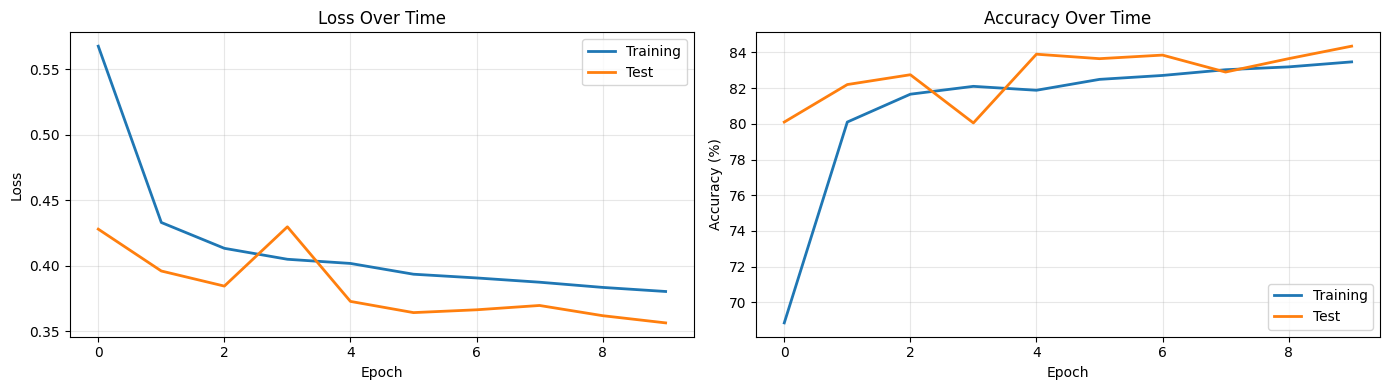


Final test accuracy: 84.35%


In [7]:
# Visualize training progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

ax1.plot(history['train_loss'], label='Training', linewidth=2)
ax1.plot(history['test_loss'], label='Test', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Over Time')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history['train_acc'], label='Training', linewidth=2)
ax2.plot(history['test_acc'], label='Test', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Accuracy Over Time')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal test accuracy: {history['test_acc'][-1]:.2f}%")


 **What just happened?**
 - The network learned to classify reviews with ~81% accuracy! The  **Loss** decreases consistently for the training set so the model is still learning and making fewer erros, but we see that the test loss is much higher than the training loss. Similarly the **Accuracy** for the training set increases consistently, but the accuracy on the test set is a bit more chaotic. This is not totally surprising and can be fine as long as the accuracy on the test set does keep increasing over time, which seems to be the case for use with the highest accuracy on the test set being obtain at the last epoch. 
 - But what if we had only run 7 epochs? In that case the accuracy on the test set would be 83.05%, but the epoch before it the test accuracy was 83.55%. So how to we determine the best epoch to select our model from? We will discuss that in the part below.
 

### Datasplits: Train, Test and ... **Validation**!
In the above example we saw that the accuracy on the training split was much higher than on the test split. As long as the performance on the test split still increases this can be fine. However, at some point the model starts to memorize features/aspects of the input which might not reflect general patterns but only hold for the cases in that specific split. The model than seems to memorize the training data instead of learning general patterns, this process is called **Overfitting**. As we do not want this, we want to obtain the model trained at the perfect point in training where it has learned the best general patterns. We could use evaluate on the test set every epoch and select the best epoch, but from a scientific point of view this is also flawed. We might select an epoch where the model happends to do best at the test set, but also in a non generalizable way (heck it might even do relativly bad on the training set in this epoch). Our solution to this problem is the trias politica of datascience, we introduce a smaller third split: **The Validation Split** (aka evaluation split). If our dataset doesn't already have this, we can select it as a subset of the training set (make sure to remove it from the training split then).

Thus the protocal then becomes:
1. Train for as many epochs as you can on the training split (excl valiation data)
2. Each epoch, run the trained model on the validation split: check the loss
3. Check which epoch had the best validation loss (so lowest), use this model as the best model
4. Evaluate the best model on the test set

### Split the data
- The object train_data is part of the Huggingface Dataset class, which has a nice build in function for splitting.

In [8]:
# Split train_data into train and validation sets (80/20 split)
split_data = train_data.train_test_split(test_size=0.1, seed=42)
train_data_split = split_data['train']
val_data_split = split_data['test']

# Create datasets and dataloaders with validation set
train_dataset_split = IMDBDataset(train_data_split, word2vec)
val_dataset_split = IMDBDataset(val_data_split, word2vec)

train_loader_split = DataLoader(train_dataset_split, batch_size=32, shuffle=True)
val_loader_split = DataLoader(val_dataset_split, batch_size=32, shuffle=False)

print(f"Train size: {len(train_dataset_split)}, Val size: {len(val_dataset_split)}, Test size: {len(test_dataset)}")

Train size: 9000, Val size: 1000, Test size: 2000


In [9]:
def train_model_with_validation(model, train_loader, val_loader, epochs=10, lr=0.001, verbose=True):
    """Train the model with validation and save the best model based on validation loss."""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Track metrics over time
    history = {
        'train_loss': [], 
        'train_acc': [], 
        'val_loss': [], 
        'val_acc': []
    }
    
    # Track the best model
    best_val_loss = float('inf')
    best_model_state = None
    best_epoch = -1
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        # Evaluate on validation set
        val_loss, val_acc = evaluate_model_on_split(model, val_loader, criterion, device)
        
        # Record metrics
        history['train_loss'].append(train_loss / len(train_loader))
        history['train_acc'].append(100 * train_correct / train_total)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            best_epoch = epoch+1
            if verbose:
                print(f"Epoch {epoch+1}/{epochs} - "
                    f"Train Loss: {history['train_loss'][-1]:.4f}, "
                    f"Train Acc: {history['train_acc'][-1]:.2f}%, "
                    f"Val Loss: {val_loss:.4f}, "
                    f"Val Acc: {val_acc:.2f}% [NEW BEST MODEL]")
        else:
            if verbose:
                print(f"Epoch {epoch+1}/{epochs} - "
                    f"Train Loss: {history['train_loss'][-1]:.4f}, "
                    f"Train Acc: {history['train_acc'][-1]:.2f}%, "
                    f"Val Loss: {val_loss:.4f}, "
                    f"Val Acc: {val_acc:.2f}%")
    
    # Load the best model weights
    model.load_state_dict(best_model_state)
    print(f"\nLoaded best model at epoch {best_epoch}, with validation loss: {best_val_loss:.4f}")
    
    return model, history

# We have to reinitialize the model, since it was trained in the previous cells (otherwise we would be continuing the previous training)
model = SimpleNN(input_dim=300, hidden_dims=[128, 64], num_classes=2)

# Train the model with validation
print("\nTraining the neural network with validation...")
model, history = train_model_with_validation(model, train_loader_split, val_loader_split, epochs=20, lr=0.002)

# Evaluate the best model on the test set
print("\nEvaluating best model on test set...")
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_loss, test_acc = evaluate_model_on_split(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")


Training the neural network with validation...
Epoch 1/20 - Train Loss: 0.5361, Train Acc: 72.36%, Val Loss: 0.4090, Val Acc: 81.50% [NEW BEST MODEL]
Epoch 2/20 - Train Loss: 0.4349, Train Acc: 80.36%, Val Loss: 0.4283, Val Acc: 80.20%
Epoch 3/20 - Train Loss: 0.4190, Train Acc: 81.03%, Val Loss: 0.3915, Val Acc: 81.90% [NEW BEST MODEL]
Epoch 4/20 - Train Loss: 0.4093, Train Acc: 81.70%, Val Loss: 0.3916, Val Acc: 82.60%
Epoch 5/20 - Train Loss: 0.4096, Train Acc: 82.01%, Val Loss: 0.3870, Val Acc: 82.70% [NEW BEST MODEL]
Epoch 6/20 - Train Loss: 0.4010, Train Acc: 81.96%, Val Loss: 0.4126, Val Acc: 81.30%
Epoch 7/20 - Train Loss: 0.3938, Train Acc: 82.54%, Val Loss: 0.3975, Val Acc: 82.50%
Epoch 8/20 - Train Loss: 0.3924, Train Acc: 82.58%, Val Loss: 0.4104, Val Acc: 82.50%
Epoch 9/20 - Train Loss: 0.3857, Train Acc: 83.10%, Val Loss: 0.3837, Val Acc: 82.90% [NEW BEST MODEL]
Epoch 10/20 - Train Loss: 0.3892, Train Acc: 82.49%, Val Loss: 0.3726, Val Acc: 83.60% [NEW BEST MODEL]
Epoch 

**Observations:**
- Firstly note that we have set the learning rate a bit higher so that the model converges faster (so we can illustrate the benefit of the validation split).
- We see that the best model is indeed at epoch 10, but that not every epoch has a new best

**Motivation of Splits:**
As the overall accuracy is still increasing, we can be relatively sure that the last epoch is one of the best. The real point where the validation split shines is that it allows us to make small modifications to the training parameters called **Hyper Parameter Tuning**. For example below we have changed the learning rate a bit, but how do we know which learning rate is the best one? We use various values for the learning rate, train our model and check what the highest score on the validation set was. 

-> **Note:** that during hyper parameter tuning we should not look at the test accuracy. When we look at the test accuracy we have to be sure that we not secretly used the best training settings that only work great on the test split, so we should again use the validation split.

In [10]:
# For ease, we will overwrite the previous train_loader variables
train_loader = train_loader_split
val_loader = val_loader_split

 ## 2. Understanding the Components



 Now that we've seen a neural network work, let's understand its key components.

 ### 2.1 Activation Functions

 Activation functions introduce **non-linearity** into the network. Without them, no matter how many layers we add, the network would just be doing linear transformations (like multiplication and addition). Non-linearity allows the network to learn complex patterns.

 Common activation functions:
 - **ReLU** (Rectified Linear Unit): Most popular, outputs max(0, x)
 - **Sigmoid**: Squashes values to (0, 1), used for probabilities
 - **Tanh**: Squashes values to (-1, 1), centered around zero

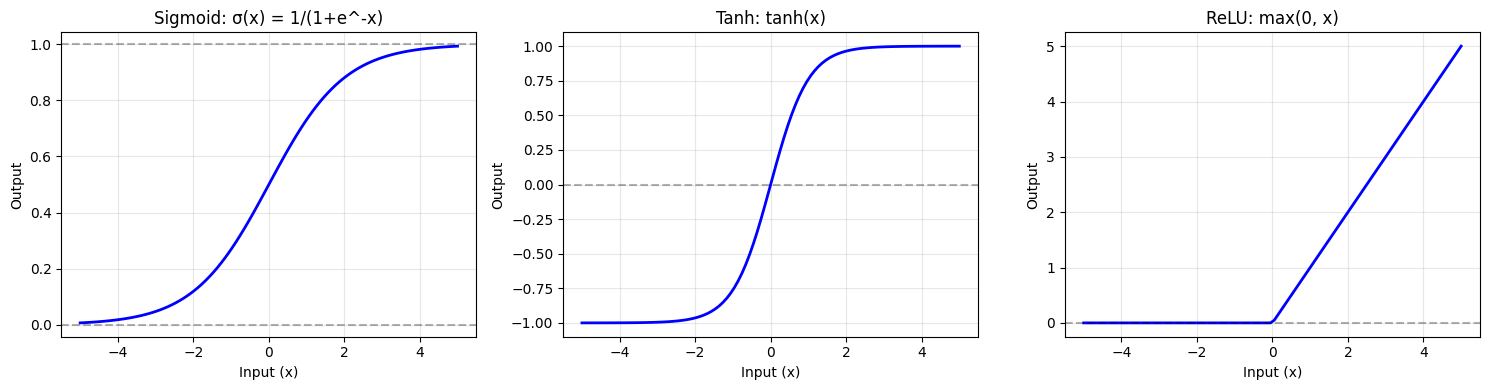

In [11]:
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

def tanh(x: np.ndarray) -> np.ndarray:
    return np.tanh(x)

def relu(x: np.ndarray) -> np.ndarray:
    return np.maximum(0, x)

# Visualize activation functions
x = np.linspace(-5, 5, 100)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(x, sigmoid(x), color='blue', linewidth=2)
axes[0].set_title('Sigmoid: σ(x) = 1/(1+e^-x)', fontsize=12)
axes[0].set_xlabel('Input (x)')
axes[0].set_ylabel('Output')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[0].axhline(y=1, color='k', linestyle='--', alpha=0.3)

axes[1].plot(x, tanh(x), color='blue', linewidth=2)
axes[1].set_title('Tanh: tanh(x)', fontsize=12)
axes[1].set_xlabel('Input (x)')
axes[1].set_ylabel('Output')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='k', linestyle='--', alpha=0.3)

axes[2].plot(x, relu(x), color='blue', linewidth=2)
axes[2].set_title('ReLU: max(0, x)', fontsize=12)
axes[2].set_xlabel('Input (x)')
axes[2].set_ylabel('Output')
axes[2].grid(True, alpha=0.3)
axes[2].axhline(y=0, color='k', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

Key properties:
- ReLU: Simple and fast, outputs 0 for negative inputs
- Sigmoid: Smooth, outputs between 0 and 1
- Tanh: Similar to sigmoid but centered at 0 (outputs between -1 and 1)

 **Why ReLU is popular:**
 - Very simple: just take the positive part
 - Fast to compute
 - Helps avoid the "vanishing gradient" problem in deep networks
 - Works well in practice!

 ### 2.2 Loss Functions
 Loss functions measure how wrong the network's predictions are. The network tries to minimize this loss during training.

 For classification tasks, we use **Cross-Entropy Loss**:
 - Heavily penalizes confident wrong predictions
 - Rewards confident correct predictions

 For regression tasks, we might use:
 - **MSE (Mean Squared Error)**: L2 loss
 - **MAE (Mean Absolute Error)**: L1 loss

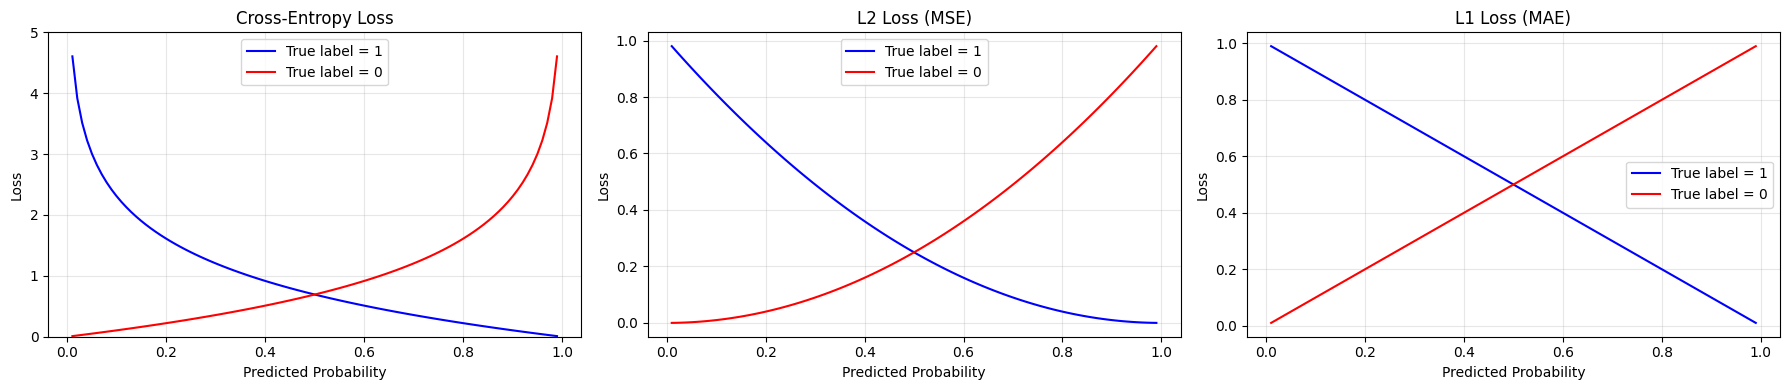

In [22]:
y_pred_range = np.linspace(0.01, 0.99, 100)
losses = [
    [ -np.log(y_pred_range), -np.log(1 - y_pred_range) ],                # Cross-Entropy
    [ (1 - y_pred_range) ** 2, (0 - y_pred_range) ** 2 ],                # L2
    [ abs(1 - y_pred_range), abs(0 - y_pred_range) ]                     # L1
]
titles = ['Cross-Entropy Loss', 'L2 Loss (MSE)', 'L1 Loss (MAE)']

fig, axes = plt.subplots(1, 3, figsize=(18, 4))
for i in range(3):
    axes[i].plot(y_pred_range, losses[i][0], label='True label = 1', color='blue')
    axes[i].plot(y_pred_range, losses[i][1], label='True label = 0', color='red')
    axes[i].set_xlabel('Predicted Probability')
    axes[i].set_ylabel('Loss')
    axes[i].set_title(titles[i])
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    if i == 0: axes[i].set_ylim([0, 5])
plt.tight_layout()
plt.show()


Key insight:
- The main difference in how these models differ in what type of errors they penalize. 
- Cross-Entropy (used in our model) heavily penalizes wrong predictions, especially when the model is confident but wrong. This helps the network learn faster and more accurately for classification tasks.


Let's use a more concrete example! What if I wrongfully predict the label to be 1 with probability 0.6 or 0.9?

In [13]:
# Let's say for binary classification I wrongfully predict class 1, with probability  0.6 or with 0.9
# What would be the loss according to different loss functions?
y_true = 0  # True label is class 0
y_pred_1 = 0.6  # Wrong prediction with probability 0.6
y_pred_2 = 0.9  # Wrong prediction with probability 0.9

def bin_cross_entropy_loss(y_true, y_pred):
    return - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def l2_loss(y_true, y_pred):
    return (y_true - y_pred) ** 2

def l1_loss(y_true, y_pred):
    return abs(y_true - y_pred)

print("Let's see how much we pay for different mistakes:")

print("\n L1 Loss:")
l1_loss_1 = l1_loss(y_true, y_pred_1)
l1_loss_2 = l1_loss(y_true, y_pred_2)
print(f"- (y_pred_1 = {y_pred_1}): {l1_loss_1:.3f}")
print(f"- (y_pred_2 = {y_pred_2}): {l1_loss_2:.3f}")
print(f"    - Difference in loss: {l1_loss_2 - l1_loss_1:.3f}")

print("\n L2 Loss:")
l2_loss_1 = l2_loss(y_true, y_pred_1)
l2_loss_2 = l2_loss(y_true, y_pred_2)
print(f"- (y_pred_1 = {y_pred_1}): {l2_loss_1:.3f}")
print(f"- (y_pred_2 = {y_pred_2}): {l2_loss_2:.3f}")
print(f"    - Difference in loss: {l2_loss_2 - l2_loss_1:.3f}")


bce_loss_1 = bin_cross_entropy_loss(y_true, y_pred_1)
bce_loss_2 = bin_cross_entropy_loss(y_true, y_pred_2)
print("\n Binary Cross-Entropy Loss:")
print(f"- (y_pred_1 = {y_pred_1}): {bce_loss_1:.3f}")
print(f"- (y_pred_2 = {y_pred_2}): {bce_loss_2:.3f}")
print(f"    - Difference in loss: {bce_loss_2 - bce_loss_1:.3f}")




Let's see how much we pay for different mistakes:

 L1 Loss:
- (y_pred_1 = 0.6): 0.600
- (y_pred_2 = 0.9): 0.900
    - Difference in loss: 0.300

 L2 Loss:
- (y_pred_1 = 0.6): 0.360
- (y_pred_2 = 0.9): 0.810
    - Difference in loss: 0.450

 Binary Cross-Entropy Loss:
- (y_pred_1 = 0.6): 0.916
- (y_pred_2 = 0.9): 2.303
    - Difference in loss: 1.386


**Observation**
- The different loss functions penalize wrong predictions in different ways. Cross Entropy is the most strict and heavily penalizes confident wrong predictions, after which it is the L2 loss then the L1 loss. 

**Intuition of why we use the different loss functions?**
- For regression we try to fit a function to our data, but this data is usually assumed to be noisy and we don't think there exists a perfect line. So when we encounter outliers we don't want to penalize this too much. 
- But for classification we are often pretty convinved that the labeled data can be split up perfectly in the different groups. So if the model confidently makes a wrong mistake it might learn to neglect a part of the data. So if the model does not know for sure, we want this to be reflected in the predicted probabilities, and we penalize it when it is very confidently wrong.

 ### 2.3 Optimizers
 Optimizers determine **how** the network updates its weights to reduce loss. Think of it as navigating down a mountain (loss) to find the valley (minimum loss).

 Common optimizers:
 - **SGD (Stochastic Gradient Descent)**: Basic, follows the gradient directly
 - **Adam**: Advanced, adapts learning rate for each parameter (what we used!)
 - **RMSprop**: Another adaptive method (leave this for now, just fyi)

 **Adam** is popular because:
 - It adjusts learning rate automatically for each parameter
 - Works well with minimal tuning
 - Converges faster than basic SGD

In [15]:
# Compare different optimizers on our task
print("Comparing optimizers...")

optimizers_to_test = {
    'SGD': optim.SGD,
    'Adam': optim.Adam,
    # 'RMSprop': optim.RMSprop  # You can try this, but let's keep our analysis simple for now
}

optimizer_histories = {}

for opt_name, opt_class in optimizers_to_test.items():
    print(f"\nTraining with {opt_name}...")
    model_test = SimpleNN(input_dim=300, hidden_dims=[128, 64], num_classes=2)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_test = model_test.to(device)
    
    criterion = nn.CrossEntropyLoss()

    if opt_name == 'SGD':
        optimizer = opt_class(model_test.parameters(), lr=0.3)  # Higher LR for SGD
    else:
        optimizer = opt_class(model_test.parameters(), lr=0.001)
    
    history = {'train_loss': [], 'val_acc': []}
    
    for epoch in range(5):  # Just 5 epochs for comparison
        model_test.train()
        train_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model_test(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        # print(f"Epoch {epoch+1}, Batch Loss: {loss.item():.4f}")
        print(f"Epoch {epoch+1} - Training Loss: {train_loss / len(train_loader):.4f}")
        
        test_loss, val_acc = evaluate_model_on_split(model_test, val_loader, criterion, device)

        
        history['train_loss'].append(train_loss / len(train_loader))
        history['val_acc'].append(val_acc)
    
    optimizer_histories[opt_name] = history
    print(f"  Final accuracy: {history['val_acc'][-1]:.2f}%")


Comparing optimizers...

Training with SGD...
Epoch 1 - Training Loss: 0.6938
Epoch 2 - Training Loss: 0.6784
Epoch 3 - Training Loss: 0.6346
Epoch 4 - Training Loss: 0.5873
Epoch 5 - Training Loss: 0.5483
  Final accuracy: 76.10%

Training with Adam...
Epoch 1 - Training Loss: 0.5785
Epoch 2 - Training Loss: 0.4442
Epoch 3 - Training Loss: 0.4180
Epoch 4 - Training Loss: 0.4124
Epoch 5 - Training Loss: 0.4036
  Final accuracy: 82.70%


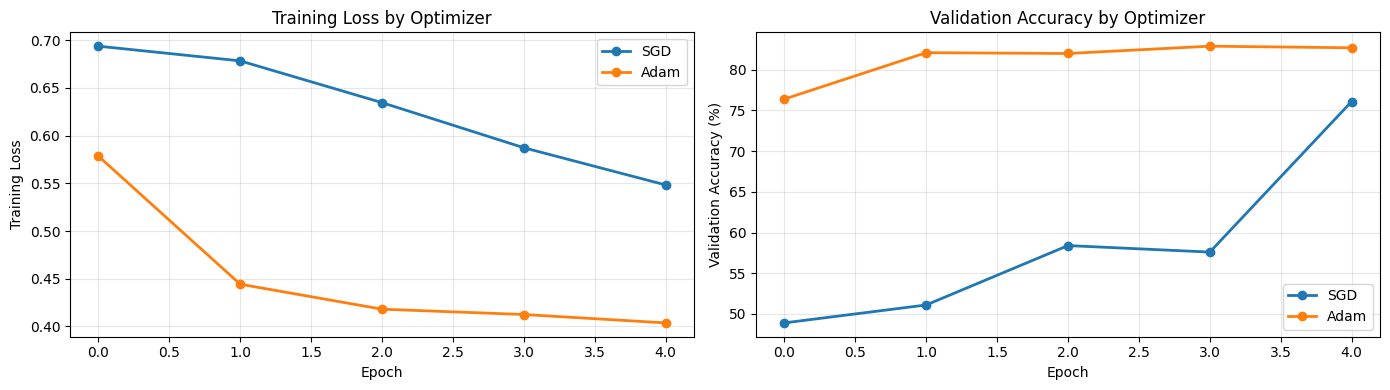

In [16]:
# Visualize optimizer comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

for opt_name, history in optimizer_histories.items():
    ax1.plot(history['train_loss'], label=opt_name, linewidth=2, marker='o')
    ax2.plot(history['val_acc'], label=opt_name, linewidth=2, marker='o')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss')
ax1.set_title('Training Loss by Optimizer')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Validation Accuracy (%)')
ax2.set_title('Validation Accuracy by Optimizer')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


 **Observation:** Adam typically converges faster and more reliably than SGD, which is why it's the default choice for many tasks.

 ## 3. Experimenting with Architectures

 Let's see how different network depths affect performance. We'll compare:
 - 1 layer network (shallow)
 - 2 layer network (medium)
 - 3 layer network (deeper)

In [17]:
architectures = {
    '1 layer (128)': [128],
    '2 layers (128→64)': [128, 64],
    '3 layers (256→128→64)': [256, 128, 64]
}

arch_histories = {}

criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for name, hidden_dims in architectures.items():
    print(f"\n{'='*50}")
    print(f"Training: {name}")
    print(f"{'='*50}")
    
    model = SimpleNN(input_dim=300, hidden_dims=hidden_dims, num_classes=2)

    # Train with validation set
    model, history = train_model_with_validation(model, train_loader_split, val_loader_split, epochs=10, lr=0.001, verbose=False)

    # Evaluate the best model on the test set
    print("\nEvaluating best model on test set...")
    test_loss, test_acc = evaluate_model_on_split(model, test_loader, criterion, device)
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    history['test_acc'] = test_acc  # Store final test accuracy
    arch_histories[name] = history



Training: 1 layer (128)

Loaded best model at epoch 10, with validation loss: 0.3848

Evaluating best model on test set...
Test Loss: 0.3660, Test Acc: 84.00%

Training: 2 layers (128→64)

Loaded best model at epoch 9, with validation loss: 0.3743

Evaluating best model on test set...
Test Loss: 0.3879, Test Acc: 81.50%

Training: 3 layers (256→128→64)

Loaded best model at epoch 8, with validation loss: 0.3735

Evaluating best model on test set...
Test Loss: 0.3712, Test Acc: 83.50%


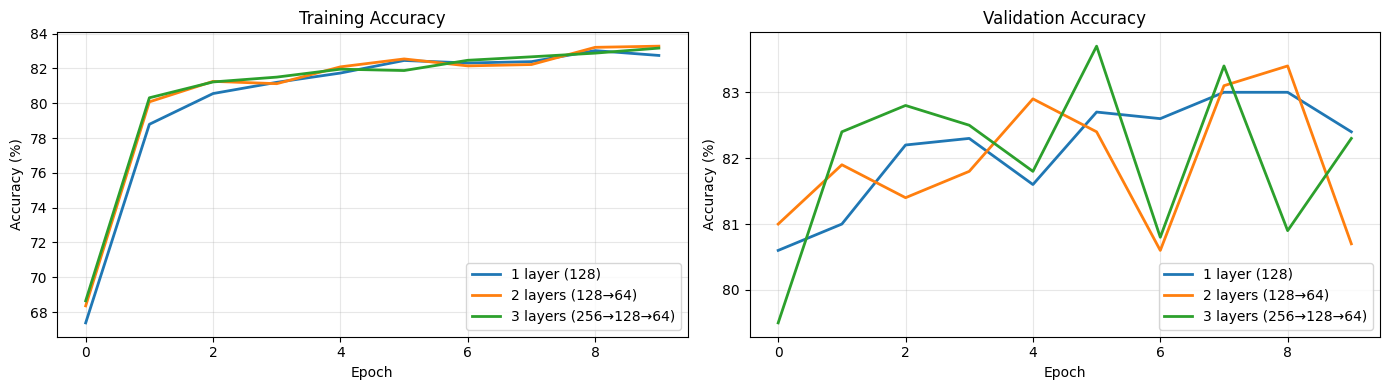


Final Performance Summary:
-------------------------------------------------------------------------------------
Architecture              Last_Train_Acc  Last_Val_Acc    Best Epoch   Test Acc    
-------------------------------------------------------------------------------------
1 layer (128)                    82.74%         82.40%           8       84.00%
2 layers (128→64)                83.28%         80.70%           9       81.50%
3 layers (256→128→64)            83.17%         82.30%           6       83.50%
The best epoch is determined based on the highest validation accuracy achieved during training. The model after that epoch is then evaluated on the test set to report the final test accuracy.


In [18]:
# Visualize architecture comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

for name, history in arch_histories.items():
    axes[0].plot(history['train_acc'], label=name, linewidth=2)
    axes[1].plot(history['val_acc'], label=name, linewidth=2)

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_title('Training Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
# Performance summary
print("\nFinal Performance Summary:")
print("-" * 85)
print(f"{'Architecture':<25} {'Last_Train_Acc':<15} {'Last_Val_Acc':<15} {'Best Epoch':<12} {'Test Acc':<12}")
print("-" * 85)

for name, hidden_dims in architectures.items():
    history = arch_histories[name]
    train_acc = history['train_acc'][-1]
    val_acc = history['val_acc'][-1]
    best_epoch = int(np.argmax(history['val_acc'])) + 1  # epochs are 1-based
    test_acc = history['test_acc']
    print(f"{name:<25} {train_acc:>12.2f}% {val_acc:>13.2f}% {best_epoch:>11} {test_acc:>11.2f}%")

print(f"The best epoch is determined based on the highest validation accuracy achieved during training. The model after that epoch is then evaluated on the test set to report the final test accuracy.")

Key takeaway: 
- Deeper networks can learn more complex patterns, but they also have more parameters and may overfit if not careful.

 ## 4. (Optional): Under the Hood with NumPy



 This section is optional but educational! We'll implement a simple neural network from scratch using NumPy to understand what PyTorch does automatically.



 **Note:** This is for learning purposes only. Always use PyTorch or TensorFlow for real projects!

In [19]:
# Activation functions and derivatives for NumPy implementation
def sigmoid_derivative(x: np.ndarray) -> np.ndarray:
    s = sigmoid(x)
    return s * (1 - s)

def relu_derivative(x: np.ndarray) -> np.ndarray:
    return (x > 0).astype(float)

class NumpyNN:
    """A simple neural network from scratch - for educational purposes only!"""
    
    def __init__(self, input_size: int, hidden_size: int, output_size: int, 
                 learning_rate: float = 0.01):
        # Initialize weights with small random values
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))
        self.learning_rate = learning_rate
        
    def forward(self, X: np.ndarray):
        """Forward pass: calculate predictions."""
        # Hidden layer: X * W1 + b1, then ReLU
        z1 = np.dot(X, self.W1) + self.b1
        a1 = relu(z1)
        
        # Output layer: a1 * W2 + b2, then Sigmoid
        z2 = np.dot(a1, self.W2) + self.b2
        a2 = sigmoid(z2)
        
        return z1, a1, a2
    
    def backward(self, X: np.ndarray, y: np.ndarray, z1: np.ndarray, 
                 a1: np.ndarray, a2: np.ndarray):
        """Backward pass: calculate gradients and update weights."""
        m = X.shape[0]
        
        # Output layer gradients
        dz2 = a2 - y
        dW2 = np.dot(a1.T, dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m
        
        # Hidden layer gradients
        dz1 = np.dot(dz2, self.W2.T) * relu_derivative(z1)
        dW1 = np.dot(X.T, dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m
        
        # Update weights
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2
    
    def train(self, X: np.ndarray, y: np.ndarray, epochs: int = 1000):
        """Train the network."""
        losses = []
        for epoch in range(epochs):
            z1, a1, a2 = self.forward(X)
            
            # Binary cross-entropy loss
            loss = -np.mean(y * np.log(a2 + 1e-8) + (1 - y) * np.log(1 - a2 + 1e-8))
            losses.append(loss)
            
            self.backward(X, y, z1, a1, a2)
            
            if epoch % 200 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")
        
        return losses
    
    def predict(self, X: np.ndarray):
        """Make predictions."""
        _, _, a2 = self.forward(X)
        return (a2 > 0.5).astype(int)


 ### Testing on the XOR Problem
 XOR (exclusive OR) is a classic problem that cannot be solved by a linear model. It outputs 1 if inputs are different, 0 if they're the same:

 | Input 1 | Input 2 | Output |
 |---------|---------|--------|
 |    0    |    0    |   0    |
 |    0    |    1    |   1    |
 |    1    |    0    |   1    |
 |    1    |    1    |   0    |

Training NumPy network on XOR problem...
Epoch 0, Loss: 0.6931
Epoch 200, Loss: 0.5014
Epoch 400, Loss: 0.4792
Epoch 600, Loss: 0.4780
Epoch 800, Loss: 0.4777

Predictions:
----------------------------------------
Input: [0 0]  →  True: 0, Predicted: 1
Input: [0 1]  →  True: 1, Predicted: 1
Input: [1 0]  →  True: 1, Predicted: 1
Input: [1 1]  →  True: 0, Predicted: 0


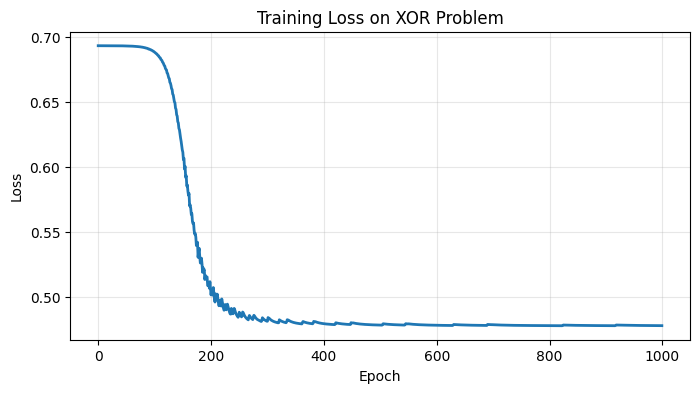

In [20]:
# XOR dataset
X_xor = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_xor = np.array([[0], [1], [1], [0]])

# Train NumPy network
numpy_nn = NumpyNN(input_size=2, hidden_size=4, output_size=1, learning_rate=0.5)
print("Training NumPy network on XOR problem...")
losses = numpy_nn.train(X_xor, y_xor, epochs=1000)

# Make predictions
predictions = numpy_nn.predict(X_xor)
print("\nPredictions:")
print("-" * 40)
for i, (x, y_true, y_pred) in enumerate(zip(X_xor, y_xor, predictions)):
    print(f"Input: {x}  →  True: {y_true[0]}, Predicted: {y_pred[0]}")

# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(losses, linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss on XOR Problem')
plt.grid(True, alpha=0.3)
plt.show()


Success! The network learned the XOR function.
This shows why we need non-linear activation functions (ReLU, Sigmoid).

 ## 5. Self-Check Questions
 Test your understanding by answering these questions:

 #### Basic Concepts
 1. What are the three main steps in training a neural network?
 2. Why do we need to convert text into numbers before feeding it to a neural network?
 3. What is the CBOW representation, and how is it computed?

 #### Components
 4. What role do activation functions play in neural networks?
 5. Name three common activation functions and describe when you might use ReLU.
 6. What does the loss function measure? Why is Cross-Entropy Loss good for classification?
 7. What is the purpose of an optimizer? Why is Adam popular?

#### Architecture & Training
 8. What happens if we make a network deeper (more layers)?
 9. Looking at the training plots (train and validation loss), how can you tell if a model is overfitting?
 10. In the code, what does `model.train()` and `model.eval()` do?
 11. What is the purpose of dropout in the network? (we didn't discuss this indept but good to know, check it out online :))

 #### Questions for possible extension
 12. How would you modify the network to classify into 5 categories instead of 2?
 13. How would you modify the neural network implementation for regression? what would the labels be, what would the loss function be?

